## Test model using simulated data

### This handbook uses parameters from Autism Data to:

#### Simulate data. 

#### Estimate parameters ($pi, \bar{\gamma}$) using MCMC from the rstan package, and the method of moments.

## Load data and parameters from Autism data

In [1]:
data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data

N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)
#data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF,
                         data$dn.mis3, data$case.mis3+data$trans.mis3,
                         data$ctrl.mis3+data$ntrans.mis3))
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]


## Use simulation functions from the TADA package

In [2]:
# Generate simulation data of a set of genes (multiple mutational categories): de novo mutations only
# N: sample size (number of trios)
# mu: mutation rate of each gene (a vector)
# mu.frac: for each type of mutation, its fraction of the gene's mutation rate
# pi: the fraction of risk genes 
# gamma.mean, beta: Relative risk of de novo mutation: gamma|M1 ~ Gamma(gamma.mean*beta, beta). Vectors (one per category) 
# Output: sample matrix (m by K), where m is the number of genes and K the number of variant categories. sample.info: more information of the samples, including the indicator (risk gene or not) and the RR. 

simulator.denovo <- function(N, mu, mu.frac, pi, gamma.mean, beta) {
  m <- length(mu) # number of genes
  K <- length(mu.frac) # number of mutational categories
  
  z <- rbinom(m, 1, pi)
  gamma <- array(1, dim=c(m,K))
  x <- array(0, dim=c(m,K))
  k <- sum(z==1)
  for (j in 1:K) {
    gamma[z==1, j] <- rgamma(k, gamma.mean[j]*beta[j], beta[j])
    x[,j] <- rpois(m, 2 * mu * mu.frac[j] * gamma[,j] * N)
  }
  
  sample.info <- cbind(mu, z, gamma, x)
  
  return (list(sample=x, sample.info=sample.info))
}

# Generate simulation data of a set of genes (multiple mutational categories)
# N: sample size (number of trios)
# mu: mutation rate of each gene (a vector)
# mu.frac: for each type of mutation, its fraction of the gene's mutation rate
# pi: the fraction of risk genes 
# gamma.mean.dn, beta.dn: Relative risk of de novo mutation: gamma|M1 ~ Gamma(gamma.mean.dn*beta.dn, beta.dn). Vectors.
# gamma.mean.CC, beta.CC: Relative risk of inherited mutation (case/control): gamma.CC|M1 ~ Gamma(gamma.mean.CC*beta.CC, beta.CC). Vectors
# Frequency parameter of risk genes: q|M1 ~ Gamma(rho1, nu1)
# Frequency parameter of non-risk genes: q|M0 ~ Gamma(rho0, nu0)
# tradeoff option: if TRUE, implement q-gamma tradeoff (i.e. higher gamma means lower q). Suppose, gamma_i is the RR, then q_i is proportional to mu_i / gamma_i, where the constant is determined from the mean of q, mu and gamma. 
# Output: sample matrix (m by 3K), where m is the number of genes and K the number of variant categories.  sample.info: more information of the samples, including the indicator (risk gene or not) and the RR.
simulator <- function(N, mu, mu.frac, pi, gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0, tradeoff=FALSE) {
  m <- length(mu) # number of genes
  K <- length(mu.frac) # number of mutational categories
  
  # the tradeoff parameter (delta:=mu.mean/q.mean)
  delta <- mean(mu) * mu.frac / (rho0 / nu0)
  
  z <- rbinom(m, 1, pi)
  gamma.dn <- array(1, dim=c(m,K))
  gamma.CC <- array(1, dim=c(m,K))
  q <- array(0, dim=c(m,K))
  x <- array(0, dim=c(m,3*K))
  k <- sum(z==1)
  for (j in 1:K) {
    # sample de novo 
    gamma.dn[z==1, j] <- rgamma(k, gamma.mean.dn[j]*beta.dn[j], beta.dn[j])
    col <- 3*(j-1)+1
    x[,col] <- rpois(m, 2 * mu * mu.frac[j] * gamma.dn[,j] * N$dn)
    
    # sample case-control
    gamma.CC[z==1, j] <- rgamma(k, gamma.mean.CC[j]*beta.CC[j], beta.CC[j])
    q[z==0, j] <- rgamma(m-k, rho0[j], nu0[j])
    if (tradeoff==FALSE) {
      q[z==1, j] <- rgamma(k, rho1[j], nu1[j])
    } else {
      q[z==1, j] <- mu[z==1] * mu.frac[j] / (delta[j] * gamma.CC[z==1, j])
    }
    x[,col+1] <- rpois(m, q[,j] * gamma.CC[,j] *N$ca)
    x[,col+2] <- rpois(m, q[,j] * N$cn)
    
  }
  
  sample.info <- cbind(mu, z, gamma.dn, gamma.CC, q, x)
  
  return (list(sample=x, sample.info=sample.info))
}



## Simulate for single category

### MCMC code using rstan

In [3]:
denovoBinomSingle <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;

int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];
}
parameters {
real<lower=0.0,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFdn;
//real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
hyperGammaMeanLoFdn ~ uniform(1, 70); //normal(15, 100);
//hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn, 1);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]);

ps[2] <- log(pi0)
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]*gammaLoFdn);

increment_log_prob(log_sum_exp(ps));
}

}
"


### Simulate only single de novo category

In [19]:
sDenovo <- simulator.denovo(N = N$dn, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.2, gamma.mean = 20, beta = 1)

class(sDenovo)
str(sDenovo)

sCountDenovo <- as.numeric(sDenovo[[1]])
table(sCountDenovo)


[1] "list"

List of 2
 $ sample     : num [1:18735, 1] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:4] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "mu" "z" "" ""


sCountDenovo
    0     1     2     3     4 
18124   541    60     9     1 

### Estimate $\pi$ using the method of moments

In [20]:
source("newTADA2016/TADA/TADA.v1.1.R")


mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo

C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 1

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
gamma.mean.dn=results$gamma.mean
M.expected=results$M
listGamma[k] <- gamma.mean.dn
listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])


In [21]:
outResult <- cbind(round(listK, 2), listGamma, listM, round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")
outResult[order(outResult[, 5]), ]


nGene,GammaMean,M.expected,Risk_gene_proportion,Distance_M.ob_AND_es
500.0000,135.2628,135.1116,0.0270,475.8884
562.0500,120.4403,133.7100,0.0300,477.2900
700.00000,96.90202,129.09928,0.03700,481.90072
200.0000,336.6571,118.2168,0.0110,492.7832
1000.00000,68.13141,117.28594,0.05300,493.71406
1500.00000,45.75428,100.12571,0.08000,510.87429
2000.00000,34.56571,87.29037,0.10700,523.70963
100.00000,672.31415,82.34605,0.00500,528.65395
2500.00000,27.85257,77.62849,0.13300,533.37151
3000.00000,23.37714,70.10200,0.16000,540.89800


#### Change d

In [22]:
source("newTADA2016/TADA/TADA.v1.1.R")


mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo

C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
gamma.mean.dn=results$gamma.mean
M.expected=results$M
listGamma[k] <- gamma.mean.dn
listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])


In [23]:
outResult <- cbind(round(listK, 2), listGamma, listM, round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")
outResult[order(outResult[, 5]), ]


nGene,GammaMean,M.expected,Risk_gene_proportion,Distance_M.ob_AND_es
100.000000,672.314147,68.045245,0.005000,1.954755
500.000000,135.262829,62.139844,0.027000,7.860156
200.00000,336.65707,80.05509,0.01100,10.05509
75.00000,896.08553,58.47998,0.00400,11.52002
562.05000,120.44029,58.07172,0.03000,11.92828
700.00000,96.90202,50.14774,0.03700,19.85226
50.00000,1343.62829,44.17804,0.00300,25.82196
1000.00000,68.13141,37.62389,0.05300,32.37611
1500.00000,45.75428,25.51018,0.08000,44.48982
2000.00000,34.56571,18.75936,0.10700,51.24064


### Use function from old version of TADAT

In [26]:
source("TADA/TADA.R")

mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo

C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 
           2500, 3000, 3500, 4000, 5000, 0.2*length(yLoF))
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])

outResult <- cbind(round(listK, 2), listGamma, listM, round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")
outResult[order(outResult[, 5]), ]



nGene,GammaMean,M.expected,Risk_gene_proportion,Distance_M.ob_AND_es
3000.0000000,23.3771382,70.4044164,0.1600000,0.4044164
75.000000,896.085529,67.012973,0.004000,2.987027
3500.00000,20.18040,63.97073,0.18700,6.02927
2500.00000,27.85257,77.27698,0.13300,7.27698
3747.000000,18.916043,62.105158,0.200000,7.894842
4000.00000,17.78285,59.19249,0.21400,10.80751
100.00000,672.31415,82.34342,0.00500,12.34342
2000.00000,34.56571,87.23434,0.10700,17.23434
5000.00000,14.42628,52.07470,0.26700,17.92530
50.0000,1343.6283,48.1828,0.0030,21.8172


#### Use approximation

In [27]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo
mixdataSingle <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      Ndn = N$dn, NN = length(yLoF))                 
library("rstan")
nSeed <- 233
mLoF <- stan_model(model_code = denovoBinomSingle)

fLoF <- vb(mLoF, seed = nSeed, data = mixdataSingle)

fLoF



This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.006 seconds
1000 iterations under these settings should take 5.559 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1.000] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100    -2787.1             1.000            1.000
   200    -2775.4             0.502            1.000
   300    -2774.9             0.335            0.004   MEDIAN ELBO CONVERGED

Drawing 1000 samples from the approximate posterior... COMPLETED.


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: e7bbaacf0e818149de4ff9f10e60cad7.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd  2.5%   25%   50%   75% 97.5%
pi0                  0.17 0.01  0.15  0.17  0.17  0.18  0.19
hyperGammaMeanLoFdn 21.74 4.17 14.85 18.77 21.44 24.12 30.87
gammaLoFdn          22.32 1.19 19.96 21.55 22.34 23.11 24.70
lp__                 0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Wed Feb 24 11:19:09 2016.

#### Use MCMC

In [28]:
nIteration = 10000
nThin = floor(nIteration/1000)

testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = nIteration, chains = 1, thin = nThin, 
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn'))


SAMPLING FOR MODEL 'e7bbaacf0e818149de4ff9f10e60cad7' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1, Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1, Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1, Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1, Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1, Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1, Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1, Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1, Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1, Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1, Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1, Iteration: 10000 / 10000 [100%]  (Sampling)# 
#  Elapsed Time: 198.499 seconds (Warm-up)
#                250.343 seconds (Sampling)
#                448.842 seconds (Total)
# 


Inference for Stan model: e7bbaacf0e818149de4ff9f10e60cad7.
1 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=500.

                        mean se_mean   sd     2.5%      25%      50%      75%
pi0                     0.17    0.00 0.02     0.14     0.16     0.17     0.18
hyperGammaMeanLoFdn    22.97    0.23 5.22    14.07    18.92    22.72    25.89
lp__                -2767.87    0.06 1.24 -2770.78 -2768.44 -2767.54 -2766.95
                       97.5% n_eff Rhat
pi0                     0.22   490    1
hyperGammaMeanLoFdn    34.11   500    1
lp__                -2766.49   473    1

Samples were drawn using NUTS(diag_e) at Wed Feb 24 11:26:38 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

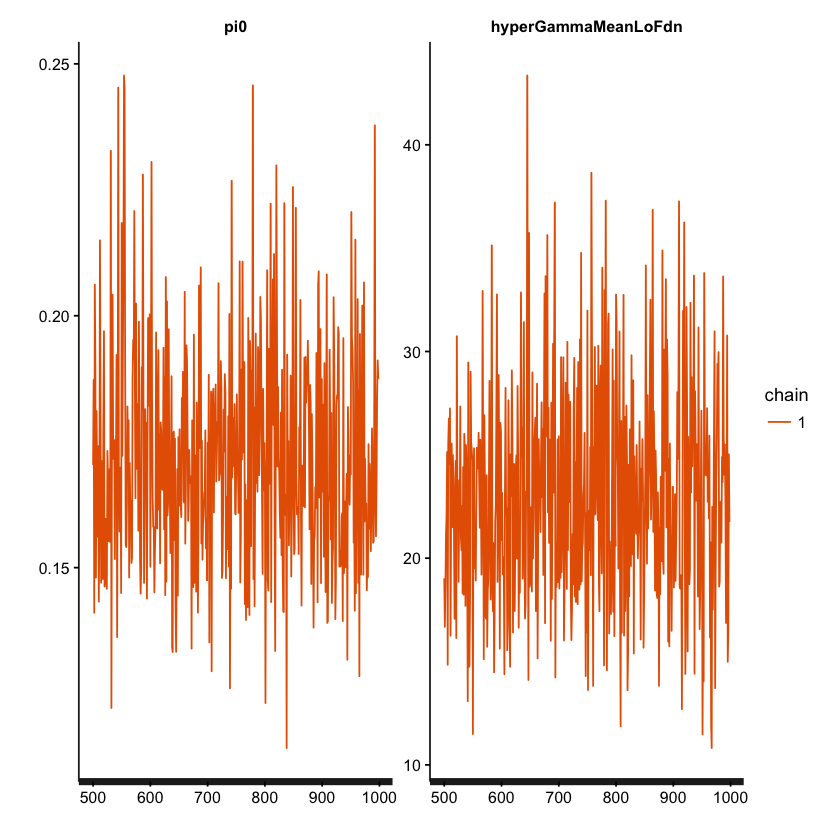

In [29]:
stan_trace(testFitSingle)
testFitSingle

### Test different $\pi$ with the method of moments

,pPredict,pList
pPredict,1.0000000,0.5878016
pList,0.5878016,1.0000000


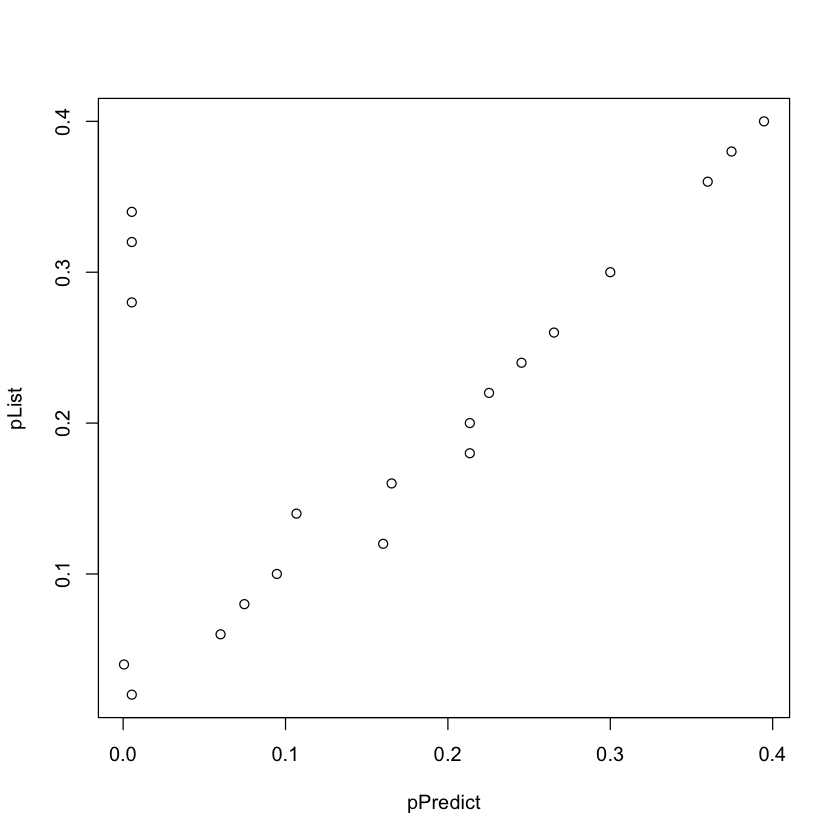

In [31]:
yLoFList <- NULL
pList <- seq(0.02, 0.4, by = 0.02)
pPredict <- NULL
for (i in 1:length(pList)){
sDenovo <- simulator.denovo(N = N$dn, mu = data$mut.rate, mu.frac = mu.frac[1], pi = pList[i], 
                            gamma.mean = 20, beta = 1)

sCountDenovo <- as.numeric(sDenovo[[1]])
table(sCountDenovo)
source("TADA/TADA.R")

mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo
yLoFList[[i]] <- yLoF
C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000, 4000, 
           pList[i]*length(yLoF), pList[i]*length(yLoF) - 100, pList[i]*length(yLoF) + 100)
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])
outResult <- cbind(listK, listGamma, listM, listK/length(yLoF), abs(listM - M.observed))
t1 <- outResult[order(outResult[, 5]), ]
pPredict[i] <- t1[1,4]
}



a1 <- cbind(pPredict, pList)
plot(a1)
cor(a1)


In [32]:
a1

pPredict,pList
0.005337603,0.020000000
0.0005337603,0.0400000000
0.06,0.06
0.0746624,0.0800000
0.0946624,0.1000000
0.1601281,0.1200000
0.1067521,0.1400000
0.1653376,0.1600000
0.2135041,0.1800000
0.2135041,0.2000000


In [35]:
outP <- NULL
for (ii in 1:length(yLoFList)){
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  yLoFList[[ii]]
mixdataSingle <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      Ndn = N$dn, NN = length(yLoF))                 
nIteration = 3000
nThin = floor(nIteration/1000)
nChain <- nCore <- 2
testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = nIteration, chains = nChain, thin = nThin, 
                      cores = nCore,
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn'))

outT <- extract(testFitSingle, pars = 'pi0')

outP[ii] <- mean(outT[[1]])
    
}

Warning message:
: There were 24 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.Warning message:
: Examine the pairs() plot to diagnose sampling problems
Warning message:
: There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.Warning message:
: Examine the pairs() plot to diagnose sampling problems


In [36]:
outP

[1] 0.04212295 0.03376377 0.05233623 0.06881728 0.10474352 0.12362089
 [7] 0.12998281 0.14445352 0.21095694 0.21337301 0.23574268 0.26279888
[13] 0.25403326 0.32226285 0.29806100 0.33656985 0.34389112 0.34526584
[19] 0.35718257 0.33387946

outP,pPredict,pList
0.042122951,0.005337603,0.020000000
0.0337637689,0.0005337603,0.0400000000
0.05233623,0.06000000,0.06000000
0.06881728,0.07466240,0.08000000
0.1047435,0.0946624,0.1000000
0.1236209,0.1601281,0.1200000
0.1299828,0.1067521,0.1400000
0.1444535,0.1653376,0.1600000
0.2109569,0.2135041,0.1800000
0.2133730,0.2135041,0.2000000


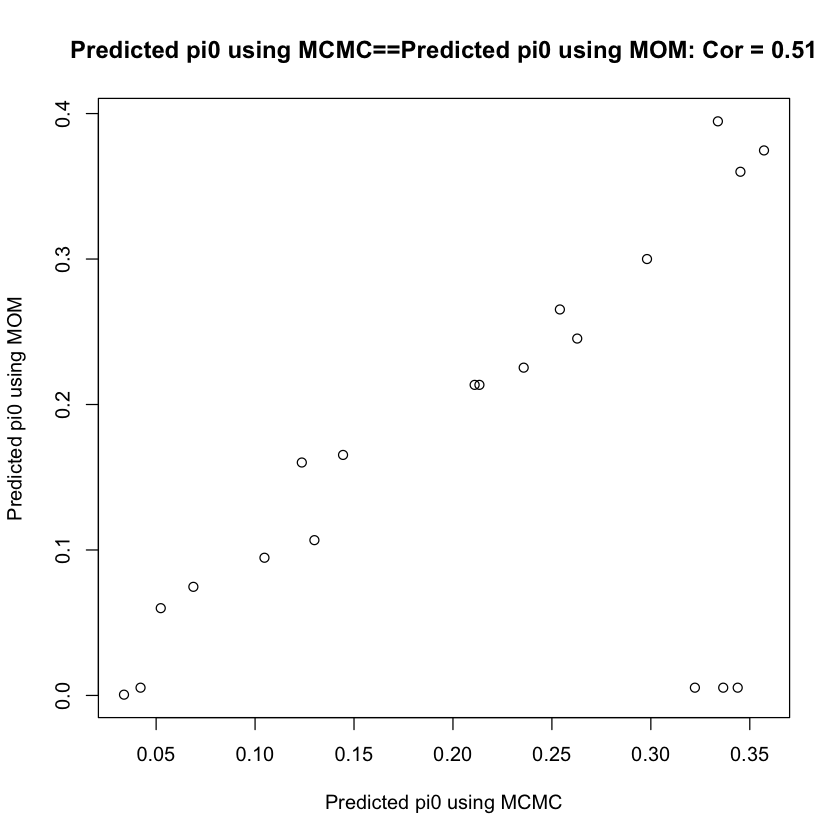

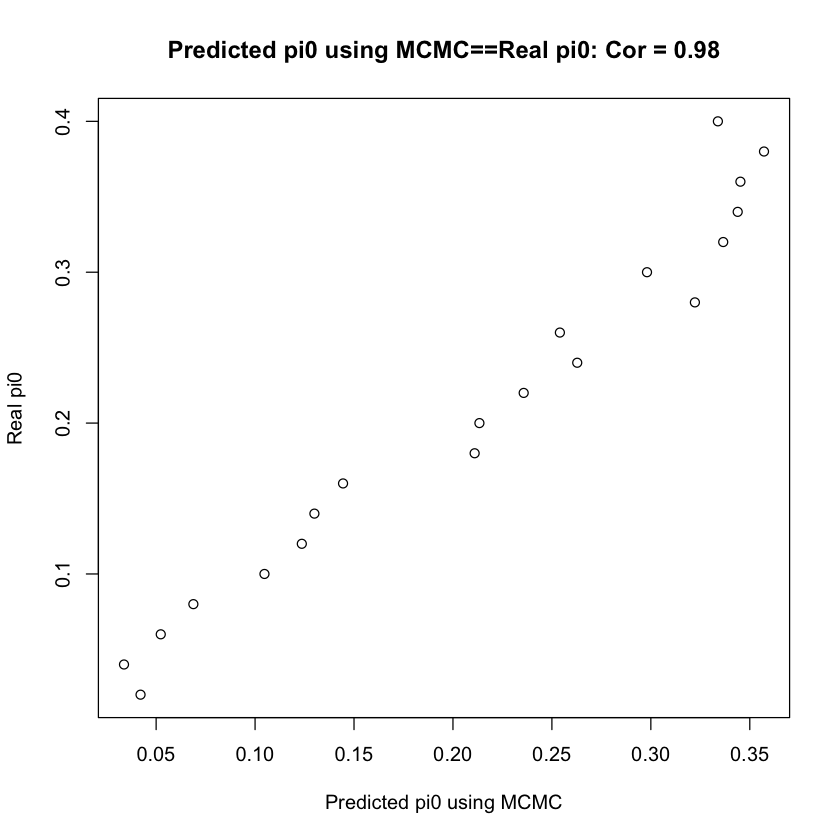

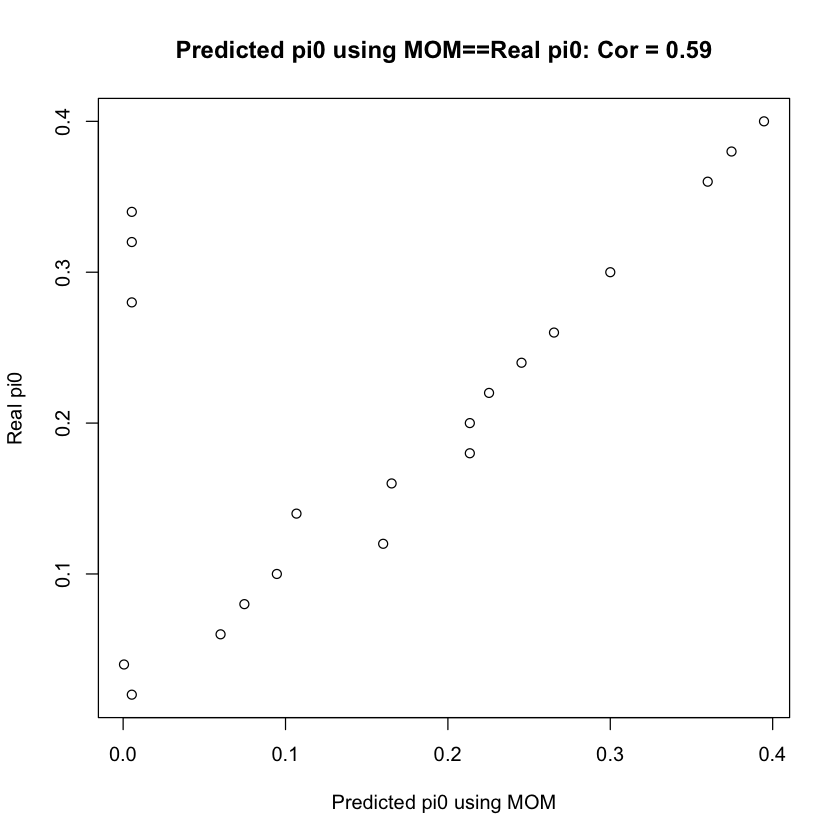

In [42]:
a3 <- cbind(outP, a1)
a3

colName <- c('Predicted pi0 using MCMC', 'Predicted pi0 using MOM', 'Real pi0')
for (i in 1:2){
    for (j in (i+1):3)
        plot(a3[, i], a3[, j], xlab = colName[i], ylab = colName[j],
            main = paste(colName[i], "==", colName[j], ": Cor = ", round(cor(a3[, i], a3[, j]), 2), sep = ""))
}


## For multiple categories

In [16]:
sDenovo2 <- simulator.denovo(N = N$dn, mu = data$mut.rate, mu.frac = mu.frac, pi = 0.06, 
                             gamma.mean = c(20, 4.7), beta = c(1, 1))

class(sDenovo2)
str(sDenovo2)

sCountDenovo2 <- (sDenovo2$sample)
str(sCountDenovo2)
muSimu <- sDenovo[[2]][, 1]

[1] "list"

List of 2
 $ sample     : num [1:18735, 1:2] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:6] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:6] "mu" "z" "" "" ...
 num [1:18735, 1:2] 0 0 0 0 0 0 0 0 0 0 ...


In [17]:
denovoBinom2 <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;

int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];
}
parameters {
real<lower=0.0,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFdn;
//real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=1> hyperGammaMeanMis3dn;
//real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;



}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
hyperGammaMeanLoFdn ~ uniform(1, 70); //normal(15, 100);
//hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn, 1);

hyperGammaMeanMis3dn ~ uniform(1, 70); //normal(15, 100);
//hyperBetaLoFdn ~ normal(1, 0.01);
gammaMis3dn ~ gamma(hyperGammaMeanMis3dn, 1);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii]);

ps[2] <- log(pi0)
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]*gammaLoFdn) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii]*gammaMis3dn);

increment_log_prob(log_sum_exp(ps));
}

}
"


In [18]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo2[, 1]

mutMis3 <- data$mut.rate*mu.frac[2]
yMis3 <- sCountDenovo2[, 2]
mixdataSingle2 <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      yMis3dn = yMis3, mutMis3 = mutMis3,
                      Ndn = N$dn, NN = length(yLoF))                 


In [19]:
library("rstan")
nSeed <- 233
mLoF2 <- stan_model(model_code = denovoBinom2)

fLoF2 <- vb(mLoF2, seed = nSeed, data = mixdataSingle2)

fLoF2

clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.010817 seconds
1000 iterations under these settings should take 10.817 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -4e+03             1.000            1.000
   200    -4236.0             0.501            1.000
   300    -4235.6             0.334            0.002   MEDIAN ELBO CONVERGED

Drawing 100

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 0854f170d14d15dcb156f0a39a75feed.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                      mean   sd  2.5%   25%   50%   75% 97.5%
pi0                   0.04 0.01  0.03  0.04  0.04  0.05  0.05
hyperGammaMeanLoFdn  26.78 7.21 15.35 21.74 25.80 30.89 43.66
gammaLoFdn           23.64 1.74 20.47 22.44 23.61 24.75 27.20
hyperGammaMeanMis3dn  4.20 1.91  1.89  2.87  3.72  4.94  9.44
gammaMis3dn           3.25 0.62  2.30  2.80  3.17  3.59  4.73
lp__                  0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 16:36:55 2016.

In [22]:
nIteration = 10000
nThin = floor(nIteration/1000)

testFitSingle2 <- stan(model_code = denovoBinom2,
                      data = mixdataSingle2, iter = nIteration, chains = 1, thin = nThin, 
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn', 'hyperGammaMeanMis3dn'))


SAMPLING FOR MODEL '0854f170d14d15dcb156f0a39a75feed' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1, Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1, Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1, Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1, Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1, Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1, Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1, Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1, Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1, Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1, Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1, Iteration: 10000 / 10000 [100%]  (Sampling)# 
#  Elapsed Time: 389.337 seconds (Warm-up)
#                459.99 seconds (Sampling)
#                849.326 seconds (Total)
# 


Inference for Stan model: 0854f170d14d15dcb156f0a39a75feed.
1 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=500.

                         mean se_mean   sd     2.5%      25%      50%      75%
pi0                      0.04    0.00 0.01     0.03     0.04     0.04     0.05
hyperGammaMeanLoFdn     25.58    0.31 6.91    13.56    20.86    25.00    29.86
hyperGammaMeanMis3dn     4.31    0.08 1.79     1.40     2.96     3.99     5.51
lp__                 -4226.32    0.08 1.66 -4230.26 -4227.17 -4226.00 -4225.10
                        97.5% n_eff Rhat
pi0                      0.06   500    1
hyperGammaMeanLoFdn     40.38   500    1
hyperGammaMeanMis3dn     8.06   500    1
lp__                 -4224.10   440    1

Samples were drawn using NUTS(diag_e) at Tue Feb 23 16:51:42 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, 

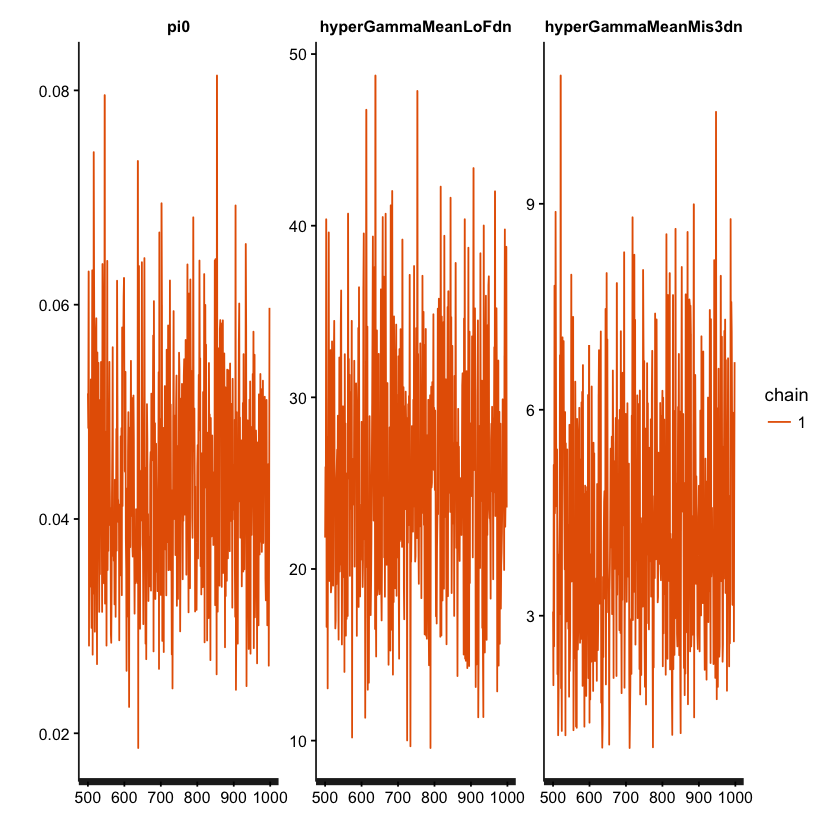

In [23]:
stan_trace(testFitSingle2)
testFitSingle2


In [30]:
source("newTADA2016/TADA/TADA.v1.1.R")
C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])
outResult <- cbind(round(listK, 0), round(listGamma, 2), round(listM, 2), 
                   round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")

outResult[order(outResult[, 5]), ]

nGene,GammaMean,M.expected,Risk_gene_proportion,Distance_M.ob_AND_es
50.000000,363.360000,21.560000,0.003000,3.442845
75.000000,242.570000,20.970000,0.004000,4.034708
100.000000,182.180000,19.290000,0.005000,5.709464
200.0000,91.5900,12.9900,0.0110,12.0056
10.00000,1812.81000,9.34000,0.00100,15.65526
500.00000,37.24000,5.51000,0.02700,19.48906
562.00000,33.24000,4.85000,0.03000,20.15488
700.00000,26.88000,3.77000,0.03700,21.22658
1000.00000,19.12000,2.48000,0.05300,22.52267
1500.00000,13.08000,1.54000,0.08000,23.45834


In [31]:
source("newTADA2016/TADA/TADA.v1.1.R")
C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 1

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])
outResult <- cbind(round(listK), round(listGamma, 2), round(listM, 2), 
                   round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")

outResult[order(outResult[, 5]), ]

nGene,GammaMean,M.expected,Risk_gene_proportion,Distance_M.ob_AND_es
100.0000,182.1800,37.3200,0.0050,230.6798
75.0000,242.5700,35.9000,0.0040,232.0969
200.000,91.590,35.270,0.011,232.729
50.0000,363.3600,31.8400,0.0030,236.1557
500.000,37.240,25.360,0.027,242.645
562.00,33.24,23.94,0.03,244.06
700.000,26.880,21.400,0.037,246.600
1000.000,19.120,17.630,0.053,250.373
1500.0000,13.0800,14.0600,0.0800,253.9353
2000.0000,10.0600,12.0300,0.1070,255.9703


## Simulate for case-control AND de novo data

In [33]:
sDenovoCC <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.15, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])

class(sDenovoCC)
str(sDenovoCC)

sCountCC <- (sDenovoCC$sample)
str(sCountCC)

head(sCountCC)


[1] "list"

List of 2
 $ sample     : num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:8] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "mu" "z" "" "" ...
 num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...


0,0,0
0,2,0
0,0,0
0,0,0
0,0,2
0,0,0


In [18]:
denovoCCBinom <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];


real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
hyperGammaMeanLoFdn ~ normal(15, 10);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"


In [35]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountCC[, 1]
y.case.lof <- sCountCC[, 2]
y.control.lof <- sCountCC[, 3]

#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
mixdataDenovoCC <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        yLoFdn = yLoF, mutLoF = mutLoF,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))


In [40]:
NSample <- 50000
mBothDenovoCC <- stan_model(model_code = denovoCCBinom)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC <- vb(mBothDenovoCC, seed = nSeed1,
                    data = mixdataDenovoCC,
                    iter = NSample, output_samples= 1000)



This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.0182 seconds
1000 iterations under these settings should take 18.2 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -1e+04             1.000            1.000
   200   -13451.8             0.504            1.000
   300   -13313.6             0.339            0.010
   400   -13327.6             0.255            0.010
   500   -13306.4             0.204            0.008   MEDIAN ELBO CONVERGED

Drawing 1000 samples from the approximate posterior.

In [41]:
fBothDenovoCC


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd  2.5%   25%   50%   75% 97.5%
pi0                  0.13 0.01  0.12  0.13  0.13  0.14  0.14
hyperGammaMeanLoFcc  3.18 0.95  1.86  2.51  2.98  3.68  5.47
hyperBetaLoFcc       4.07 0.01  4.06  4.07  4.07  4.08  4.09
gammaLoFcc           2.72 0.08  2.57  2.66  2.71  2.77  2.87
hyperGammaMeanLoFdn 20.87 3.27 15.11 18.62 20.68 22.87 27.81
hyperBetaLoFdn       1.01 0.01  0.99  1.00  1.01  1.01  1.03
gammaLoFdn          22.19 1.10 20.17 21.43 22.17 22.90 24.30
lp__                 0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 17:26:12 2016.

In [38]:
nIteration = 3000
nThin = floor(nIteration/1000)
testFitDenovoCC <- stan(model_code = denovoCCBinom,
                        data = mixdataDenovoCC, iter = nIteration, 
                        chains = 2, cores = 2, thin = nThin,
#                        control = list(adapt_delta = 0.9),
                        pars = c('pi0',
                                 'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                 'hyperBetaLoFdn', 'hyperBetaLoFcc'))


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
2 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=5000.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.13    0.00 0.01      0.12      0.13      0.13
hyperGammaMeanLoFdn     22.32    0.08 4.25     14.49     19.41     22.06
hyperGammaMeanLoFcc      3.05    0.02 0.82      1.54      2.48      3.00
hyperBetaLoFdn           1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -13267.33    0.04 1.94 -13272.05 -13268.43 -13266.96
                          75%     97.5% n_eff Rhat
pi0                      0.14      0.15  2895    1
hyperGammaMeanLoFdn     25.16     30.93  3212    1
hyperGammaMeanLoFcc      3.57      4.79  2714    1
hyperBetaLoFdn           1.01      1.02  4039    1
hyperBetaLoFcc           4.01      4.02  4456    1
lp__ 

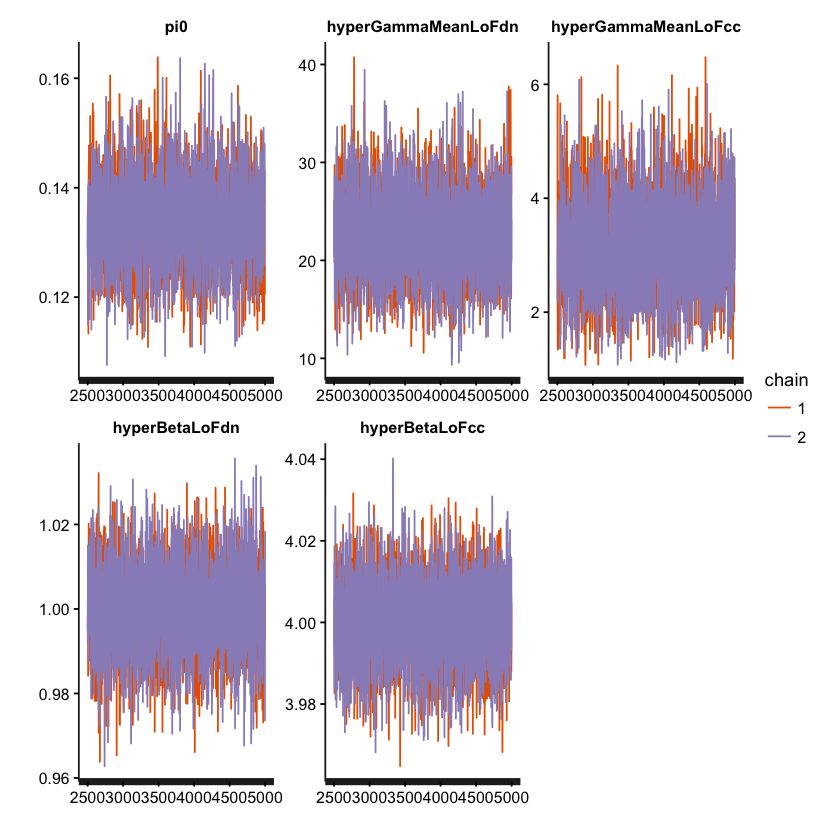

In [39]:
testFitDenovoCC
stan_trace(testFitDenovoCC)

## We will simulate case-control and de novo variants having different $\pi$

In [28]:
## Case-control with pi = 0.15
sDenovoCC <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.15, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])

class(sDenovoCC)
str(sDenovoCC)

sCountCC <- (sDenovoCC$sample)

## De novo with pi = 0.06

sDenovoCC2 <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.06, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])


sCountCC2 <- (sDenovoCC2$sample)

counts <- cbind(sCountCC2[, 1], sCountCC[, 2:3])

table(counts[, 1])
y1 <- (counts[, 1])
length(y1[y1 > 0])/length(y1)

[1] "list"

List of 2
 $ sample     : num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:8] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "mu" "z" "" "" ...



    0     1     2     3 
18423   295    11     6 

[1] 0.01665332

In [29]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  counts[, 1]
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]

#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
mixdataDenovoCC <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        yLoFdn = yLoF, mutLoF = mutLoF,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))


In [30]:
NSample <- 50000
mBothDenovoCC <- stan_model(model_code = denovoCCBinom)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC <- vb(mBothDenovoCC, seed = nSeed1,
                    data = mixdataDenovoCC)



This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.023 seconds
1000 iterations under these settings should take 23.009 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1.000] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100   -12988.8             1.000            1.000
   200   -12381.4             0.525            1.000
   300   -12401.7             0.350            0.049
   400   -12406.1             0.263            0.049
   500   -12326.1             0.212            0.006   MEDIAN ELBO CONVERGED

Drawing 1000 samples from the approximate poste

In [31]:
fBothDenovoCC

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd 2.5%  25%   50%   75% 97.5%
pi0                  0.14 0.01 0.13 0.13  0.14  0.14  0.15
hyperGammaMeanLoFcc  2.89 0.73 1.81 2.36  2.78  3.29  4.64
hyperBetaLoFcc       4.08 0.01 4.05 4.07  4.08  4.08  4.10
gammaLoFcc           2.90 0.06 2.80 2.86  2.90  2.94  3.02
hyperGammaMeanLoFdn 11.05 3.11 6.41 8.88 10.53 12.64 18.52
hyperBetaLoFdn       0.99 0.01 0.97 0.98  0.99  0.99  1.01
gammaLoFdn           9.19 0.75 7.81 8.65  9.19  9.68 10.72
lp__                 0.00 0.00 0.00 0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 21:59:59 2016.

In [32]:
nIteration = 3000
nThin = floor(nIteration/1000)
testFitDenovoCC <- stan(model_code = denovoCCBinom,
                        data = mixdataDenovoCC, iter = nIteration, 
                        chains = 2, cores = 2, thin = nThin,
#                        control = list(adapt_delta = 0.9),
                        pars = c('pi0',
                                 'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                 'hyperBetaLoFdn', 'hyperBetaLoFcc'))


In [33]:
testFitDenovoCC

Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.14    0.00 0.01      0.12      0.13      0.14
hyperGammaMeanLoFdn     10.87    0.11 3.12      5.39      8.56     10.75
hyperGammaMeanLoFcc      3.07    0.03 0.80      1.74      2.51      2.99
hyperBetaLoFdn           1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -12282.40    0.07 1.89 -12286.51 -12283.42 -12282.07
                          75%     97.5% n_eff Rhat
pi0                      0.15      0.16   863    1
hyperGammaMeanLoFdn     12.89     17.49   775    1
hyperGammaMeanLoFcc      3.58      4.90   846    1
hyperBetaLoFdn           1.01      1.02   897    1
hyperBetaLoFcc           4.01      4.02  1000    1
lp__  

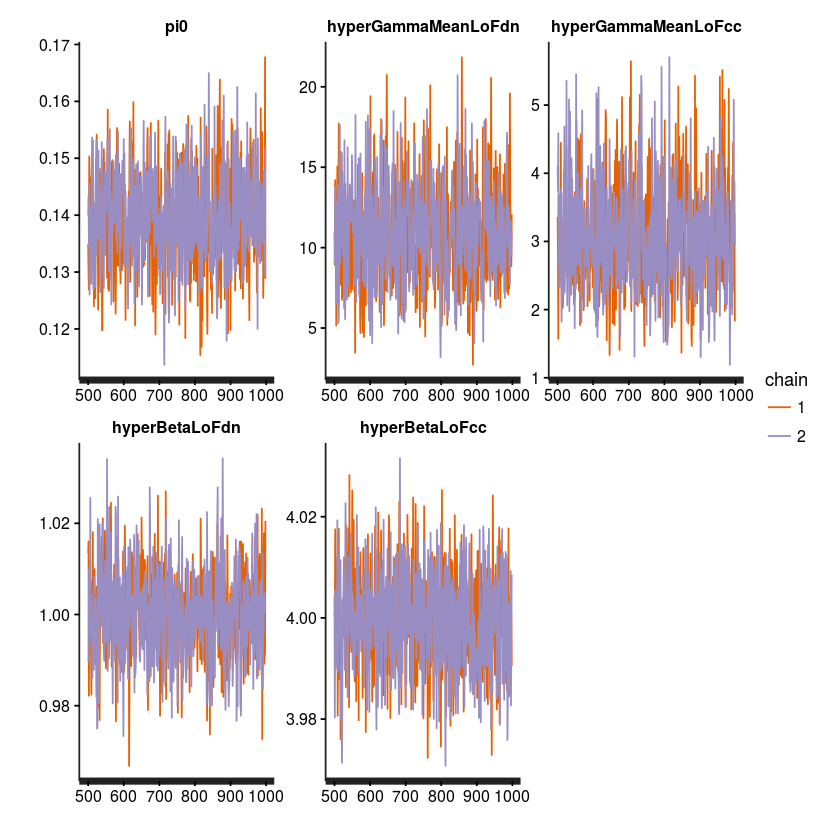

In [34]:
stan_trace(testFitDenovoCC)

In [36]:
nIteration = 3000
nThin = floor(nIteration/1000)

mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  counts[, 1]

mixdataSingle <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      Ndn = N$dn, NN = length(yLoF))                 

testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = nIteration, chains = 1, thin = nThin, 
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn'))


SAMPLING FOR MODEL 'e7bbaacf0e818149de4ff9f10e60cad7' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 3000 [  0%]  (Warmup)
Chain 1, Iteration:  300 / 3000 [ 10%]  (Warmup)
Chain 1, Iteration:  600 / 3000 [ 20%]  (Warmup)
Chain 1, Iteration:  900 / 3000 [ 30%]  (Warmup)
Chain 1, Iteration: 1200 / 3000 [ 40%]  (Warmup)
Chain 1, Iteration: 1500 / 3000 [ 50%]  (Warmup)
Chain 1, Iteration: 1501 / 3000 [ 50%]  (Sampling)
Chain 1, Iteration: 1800 / 3000 [ 60%]  (Sampling)
Chain 1, Iteration: 2100 / 3000 [ 70%]  (Sampling)
Chain 1, Iteration: 2400 / 3000 [ 80%]  (Sampling)
Chain 1, Iteration: 2700 / 3000 [ 90%]  (Sampling)
Chain 1, Iteration: 3000 / 3000 [100%]  (Sampling)# 
#  Elapsed Time: 128.292 seconds (Warm-up)
#                141.049 seconds (Sampling)
#                269.341 seconds (Total)
# 


In [37]:
testFitSingle

Inference for Stan model: e7bbaacf0e818149de4ff9f10e60cad7.
1 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=500.

                        mean se_mean   sd     2.5%      25%      50%      75%
pi0                     0.07    0.00 0.02     0.04     0.06     0.07     0.08
hyperGammaMeanLoFdn    19.82    0.35 6.08     9.35    15.73    19.19    23.58
lp__                -1579.30    0.07 1.28 -1582.54 -1579.86 -1578.99 -1578.34
                       97.5% n_eff Rhat
pi0                     0.12   327    1
hyperGammaMeanLoFdn    33.71   302    1
lp__                -1577.81   367    1

Samples were drawn using NUTS(diag_e) at Tue Feb 23 22:33:14 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

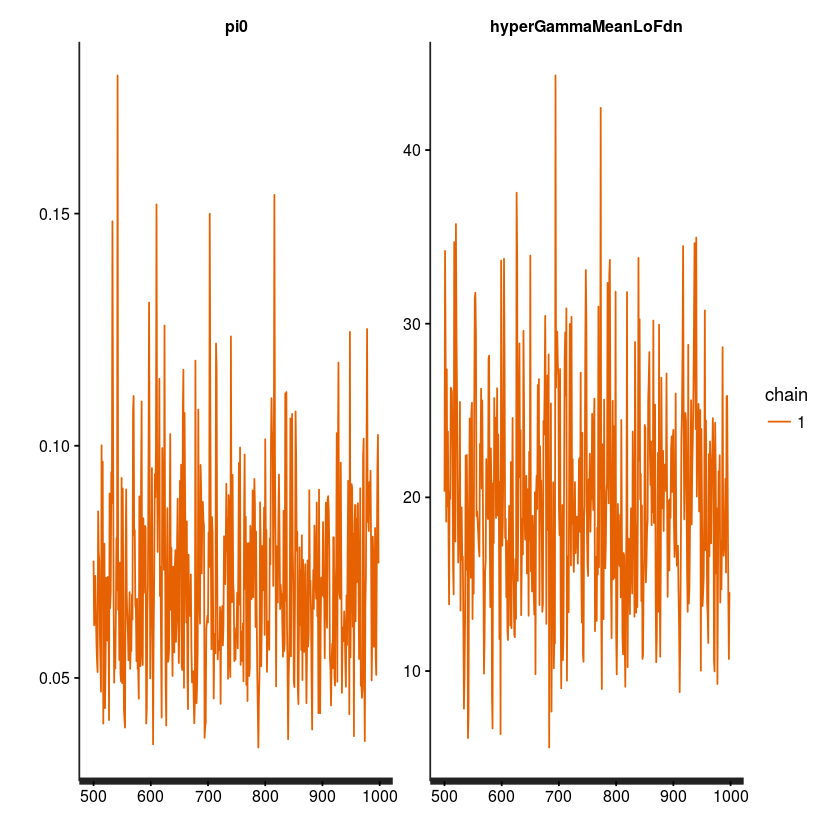

In [38]:
stan_trace(testFitSingle)

### Test for only simulated case-control data

In [40]:
onlyCCBinom <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;
int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.99> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;


}

model {

real ps[K];

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"

In [45]:
#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]

onlyCCData <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))
library("rstan")

nSeed1 <- 12345 #233
mCC <- stan_model(model_code = onlyCCBinom)
fCC <- vb(mCC, seed = nSeed1, data = onlyCCData)
fCC


This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.015099 seconds
1000 iterations under these settings should take 15.099 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Iteration: 250 / 250 [100%]  (Adaptation)
Success! Found best value [eta = 0.1].

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -6e+04             1.000            1.000
   200   -59293.6             0.521            1.000
   300  -104021.6             0.491            0.430
   400   -58118.9             0.566            0.790
   500   -55601.0             0.462            0.430
   600   -55722.4             0.385            0.43

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: bc40862a0bd2774c7ac2181e2b90a2ae.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.56 0.18 0.21 0.44 0.58 0.70  0.86
hyperGammaMeanLoFcc 2.95 2.46 1.17 1.63 2.17 3.39  9.19
hyperBetaLoFcc      1.77 2.18 0.55 0.79 1.12 1.98  6.79
gammaLoFcc          2.02 0.74 1.08 1.49 1.86 2.39  3.90
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 22:54:26 2016.

In [46]:
nIteration = 3000
nThin = floor(nIteration/1000)
nChain = nThin
nCore = nChain
testFitSingleCC <- stan(model_code = onlyCCBinom,
                      data = onlyCCData, iter = nIteration, chains = nChain,
                        thin = nThin,
                        cores = nCore,
#                      control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFcc', 'hyperBetaLoFcc'))


Inference for Stan model: bc40862a0bd2774c7ac2181e2b90a2ae.
3 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1500.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.14    0.00 0.01      0.12      0.13      0.14
hyperGammaMeanLoFcc      3.07    0.02 0.85      1.52      2.47      3.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -10357.06    0.05 1.59 -10361.11 -10357.85 -10356.66
                          75%     97.5% n_eff Rhat
pi0                      0.14      0.16  1233    1
hyperGammaMeanLoFcc      3.63      4.84  1325    1
hyperBetaLoFcc           4.01      4.02  1500    1
lp__                -10355.89 -10355.16   995    1

Samples were drawn using NUTS(diag_e) at Tue Feb 23 23:03:52 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

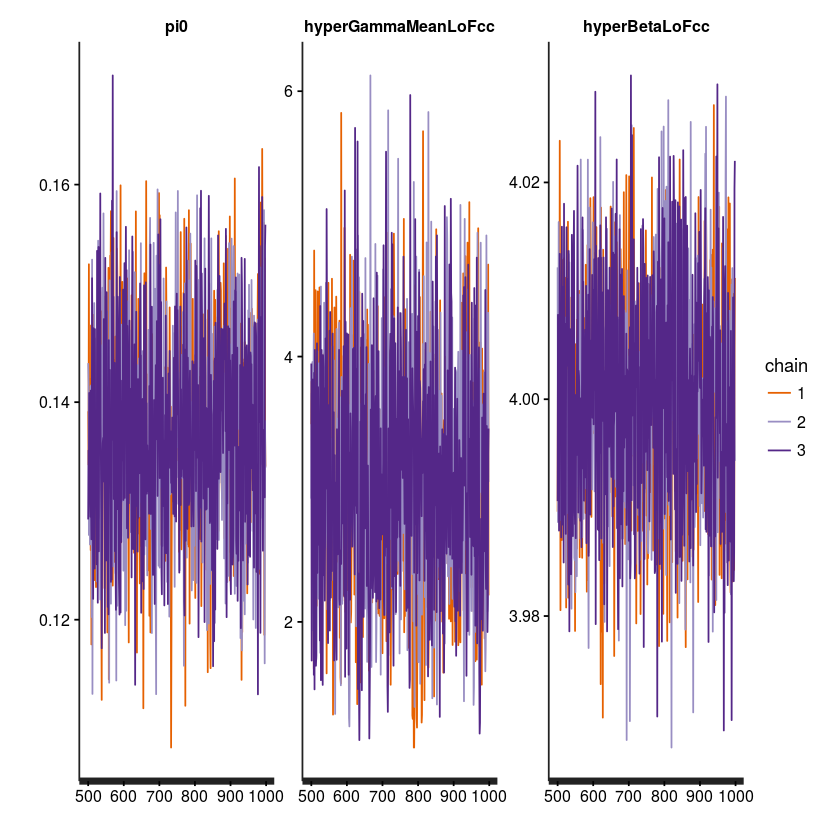

In [47]:
stan_trace(testFitSingleCC)
testFitSingleCC